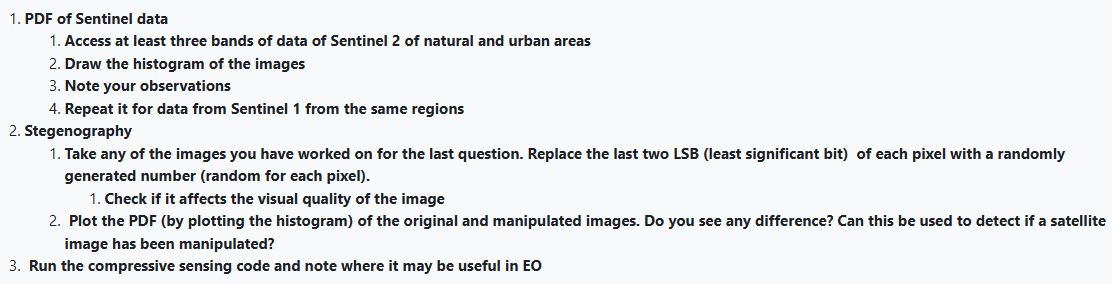

## Sentinel-2 urban and rural/forest areas analysis:

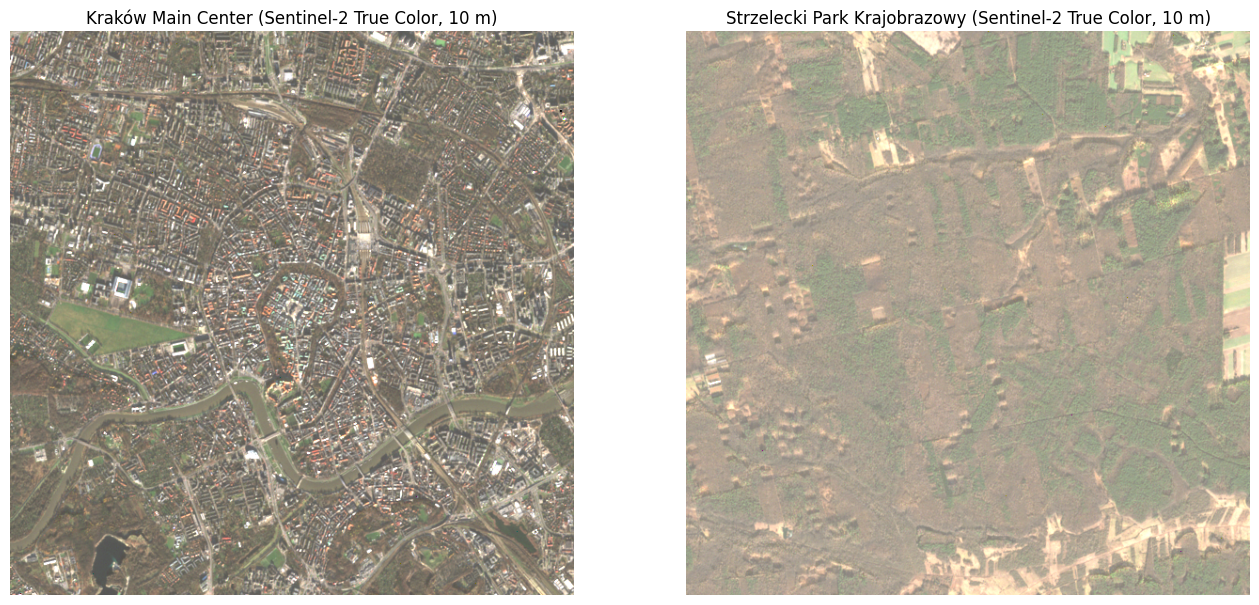

In [2]:
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import from_bounds
from pyproj import Transformer
# Paths to the 10m bands for both urban and rural areas
folder_k = "D:\\studia\\Y5S1\\ML_for_Space_Tech\\data\\K\\S2\\S2C_MSIL2A_20251119T094321_N0511_R036_T34UDA_20251119T113511.SAFE\\GRANULE\\L2A_T34UDA_A006298_20251119T094316\\IMG_DATA\\R10m"
folder_l = "D:\\studia\\Y5S1\\ML_for_Space_Tech\\data\\L\\S2\\S2C_MSIL2A_20250130T093301_N0511_R136_T34UGB_20250130T131557.SAFE\\GRANULE\\L2A_T34UGB_A002108_20250130T093257\\IMG_DATA\\R10m"
# Paths to the r g and b bands 
band_paths_k = {b: glob.glob(f"{folder_k}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}
band_paths_l = {b: glob.glob(f"{folder_l}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}

lon_k, lat_k = 19.9372205, 50.0614312   # Rynek Główny coordinates
lon_l, lat_l = 23.897058, 50.958711   # Strzelecki Park Krajobrazowy coordinates

# Transforming the image coordinates from lat/lon to UTM, taking 3km x 3km area around the point
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32634", always_xy=True)
x_k, y_k = transformer.transform(lon_k, lat_k)
x_l, y_l = transformer.transform(lon_l, lat_l)
dx = 3000   
dy = 3000   
xmin_k, ymin_k, xmax_k, ymax_k = x_k - dx, y_k - dy, x_k + dx, y_k + dy
xmin_l, ymin_l, xmax_l, ymax_l = x_l - dx, y_l - dy, x_l + dx, y_l + dy

# Helper functions to load only the cropped area of interest instead of whole image
def read_crop(path, bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)
    return data


# Crop each band for both pictures
b4_crop_k = read_crop(band_paths_k["B04"], (xmin_k, ymin_k, xmax_k, ymax_k))  # R
b3_crop_k = read_crop(band_paths_k["B03"], (xmin_k, ymin_k, xmax_k, ymax_k))  # G
b2_crop_k = read_crop(band_paths_k["B02"], (xmin_k, ymin_k, xmax_k, ymax_k))  # B

b4_crop_l = read_crop(band_paths_l["B04"], (xmin_l, ymin_l, xmax_l, ymax_l))  # R
b3_crop_l = read_crop(band_paths_l["B03"], (xmin_l, ymin_l, xmax_l, ymax_l))  # G
b2_crop_l = read_crop(band_paths_l["B02"], (xmin_l, ymin_l, xmax_l, ymax_l))  # B

# Stack, normalize, remove outliers
cropped_rgb_k = np.dstack((b4_crop_k, b3_crop_k, b2_crop_k)).astype(np.float32)
cropped_rgb_k /= np.percentile(cropped_rgb_k, 99)
cropped_rgb_k = np.clip(cropped_rgb_k, 0, 1)

cropped_rgb_l = np.dstack((b4_crop_l, b3_crop_l, b2_crop_l)).astype(np.float32)
cropped_rgb_l /= np.percentile(cropped_rgb_l, 99)
cropped_rgb_l = np.clip(cropped_rgb_l, 0, 1)

# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[1].imshow(cropped_rgb_l)
axs[1].set_title("Strzelecki Park Krajobrazowy (Sentinel-2 True Color, 10 m)")
axs[1].axis("off")
axs[0].imshow(cropped_rgb_k)
axs[0].set_title("Kraków Main Center (Sentinel-2 True Color, 10 m)")
axs[0].axis("off")
plt.show()


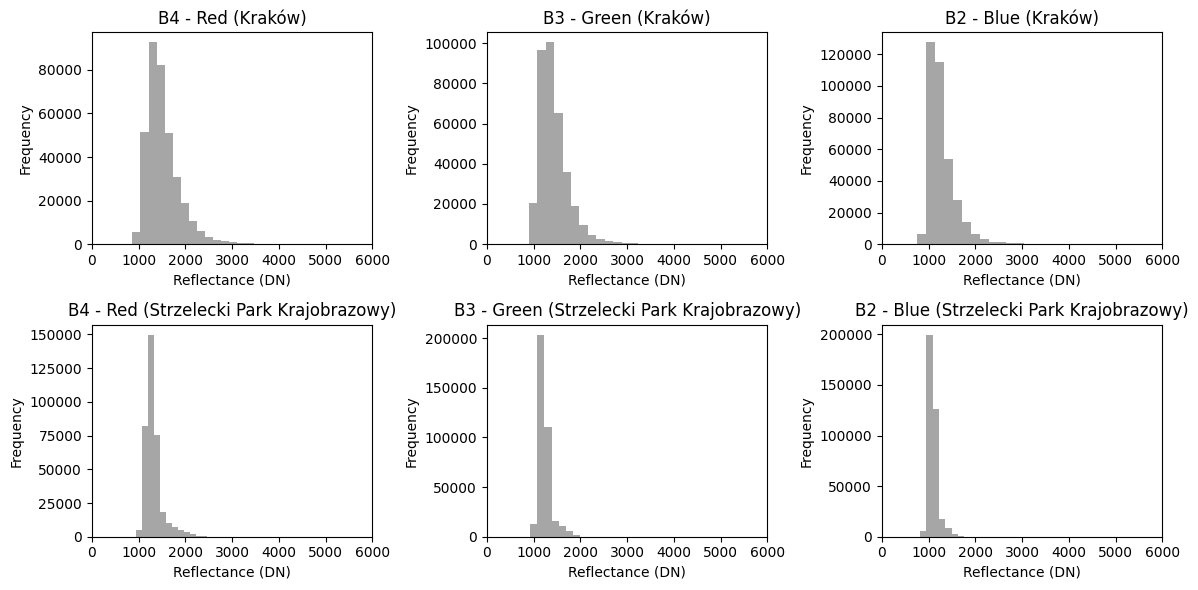

In [3]:
# Lets get all histograms for urban area and rural area, plot them and see whats up

bands_k = [b4_crop_k, b3_crop_k, b2_crop_k]
bands_l = [b4_crop_l, b3_crop_l, b2_crop_l]
names = ["B4 - Red", "B3 - Green", "B2 - Blue"]

plt.figure(figsize=(12, 6))

for i, (band, name) in enumerate(zip(bands_k, names)):
    plt.subplot(2, 3, i+1)
    plt.hist(band.flatten(), bins=100, color="gray", alpha=0.7)
    plt.title(name + " (Kraków)")
    plt.xlim(0,6000)
    plt.xlabel("Reflectance (DN)")
    plt.ylabel("Frequency")

for i, (band, name) in enumerate(zip(bands_l, names)):
    plt.subplot(2, 3, i+4)
    plt.hist(band.flatten(), bins=50, color="gray", alpha=0.7)
    plt.title(name + " (Strzelecki Park Krajobrazowy)")
    plt.xlim(0,6000)
    plt.xlabel("Reflectance (DN)")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


The rural/forest area of Strzelecki Park Krajobrazowy shows a bit less variance - tighter grouping of reflectance values.


## Sentinel-1 urban and rural/forest areas analysis:

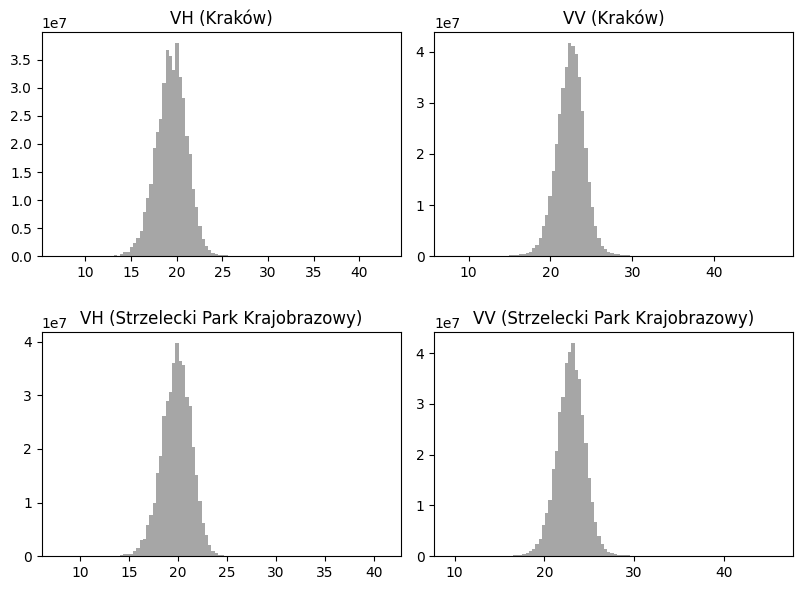

In [10]:
import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import from_bounds, Window
from pyproj import Transformer

lon_k, lat_k = 19.9372205, 50.0614312   # Rynek Główny coordinates
lon_l, lat_l = 23.897058, 50.958711   # Strzelecki Park Krajobrazowy coordinates

dx, dy    = 3000, 3000
s1_file_vh_k = "D:\\studia\\Y5S1\\ML_for_Space_Tech\\data\\K\\S1\\S1C_IW_GRDH_1SDV_20251113T162600_20251113T162625_004998_009E46_4460_COG.SAFE\\measurement\\s1c-iw-grd-vh-20251113t162600-20251113t162625-004998-009e46-002-cog.tiff"
s1_file_vv_k = "D:\\studia\\Y5S1\\ML_for_Space_Tech\\data\\K\\S1\\S1C_IW_GRDH_1SDV_20251113T162600_20251113T162625_004998_009E46_4460_COG.SAFE\\measurement\\s1c-iw-grd-vv-20251113t162600-20251113t162625-004998-009e46-001-cog.tiff"
s1_file_vh_l = "D:\\studia\\Y5S1\\ML_for_Space_Tech\\data\\L\\S1\\S1A_IW_GRDH_1SDV_20251111T044455_20251111T044520_061825_07BA94_FF31_COG.SAFE\\measurement\\s1a-iw-grd-vh-20251111t044455-20251111t044520-061825-07ba94-002-cog.tiff"
s1_file_vv_l = "D:\\studia\\Y5S1\\ML_for_Space_Tech\\data\\L\\S1\\S1A_IW_GRDH_1SDV_20251111T044455_20251111T044520_061825_07BA94_FF31_COG.SAFE\\measurement\\s1a-iw-grd-vv-20251111t044455-20251111t044520-061825-07ba94-001-cog.tiff"


def read_window(path, lon, lat, dx, dy):
    with rasterio.open(path) as src:
        
        crs_raster = src.crs or "EPSG:4326"
        transformer = Transformer.from_crs("EPSG:4326", crs_raster, always_xy=True)
        x, y = transformer.transform(lon, lat)
        transform = src.transform
        W, H = src.width, src.height
        if abs(transform.a) < 0.001: 
            dx_deg = dx / 111320
            dy_deg = dy / 111320
        else:
            dx_deg = dx
            dy_deg = dy

        xmin, ymin, xmax, ymax = x - dx_deg, y - dy_deg, x + dx_deg, y + dy_deg
        try:
            win = from_bounds(xmin, ymin, xmax, ymax, transform=transform)
        except Exception:
            rleft, rbottom, rright, rtop = src.bounds.left, src.bounds.bottom, src.bounds.right, src.bounds.top
            xmin = max(xmin, rleft)
            xmax = min(xmax, rright)
            ymin = max(ymin, rbottom)
            ymax = min(ymax, rtop)
            if xmin >= xmax or ymin >= ymax:
                
                win = Window(0, 0, W, H)
            else:
                win = from_bounds(xmin, ymin, xmax, ymax, transform=transform)

        col_off = int(np.floor(win.col_off))
        row_off = int(np.floor(win.row_off))
        width = int(np.ceil(win.width))
        height = int(np.ceil(win.height))
        col_off = max(0, min(col_off, max(0, W - 1)))
        row_off = max(0, min(row_off, max(0, H - 1)))
        width = max(0, min(width, W - col_off))
        height = max(0, min(height, H - row_off))
        if width == 0 or height == 0:
           
            return np.empty((0, 0), dtype=np.float32), crs_raster

        win = Window(col_off, row_off, width, height)
        arr = src.read(1, window=win, boundless=True, fill_value=np.nan).astype(np.float32)
        arr[arr <= 0] = np.nan
        return arr, crs_raster


s1_img_vh_k, crs1 = read_window(s1_file_vh_k, lon_k, lat_k, dx, dy)
s1_img_vv_k, crs2 = read_window(s1_file_vv_k, lon_k, lat_k, dx, dy)
s1_img_vh_l, crs3 = read_window(s1_file_vh_l, lon_l, lat_l, dx, dy)
s1_img_vv_l, crs4 = read_window(s1_file_vv_l, lon_l, lat_l, dx, dy)


if s1_img_vh_k.size == 0 and s1_img_vv_k.size > 0:
    s1_img1 = np.full_like(s1_img_vv_k, np.nan)
elif s1_img_vv_k.size == 0 and s1_img_vh_k.size > 0:
    s1_img_vv_k = np.full_like(s1_img_vh_k, np.nan)
elif s1_img_vh_k.size == 0 and s1_img_vv_k.size == 0:
    raise RuntimeError("Both loaded windows are empty. Check coordinates and input files.")


s1_db_vh_k = 10 * np.log10(s1_img_vh_k)
s1_db_vv_k = 10 * np.log10(s1_img_vv_k)
s1_db_vh_l = 10 * np.log10(s1_img_vh_l)
s1_db_vv_l = 10 * np.log10(s1_img_vv_l)

bands = [s1_db_vh_k, s1_db_vv_k, s1_db_vh_l, s1_db_vv_l]
names = ["VH (Kraków)", "VV (Kraków)", "VH (Strzelecki Park Krajobrazowy)", "VV (Strzelecki Park Krajobrazowy)"]

plt.figure(figsize=(8, 6))
for i, (band, name) in enumerate(zip(bands, names)):
    plt.subplot(2, 2, i+1)
    plt.hist(band.flatten(), bins=100, color="gray", alpha=0.7)
    plt.title(name)
plt.tight_layout()
plt.show()


Here, while shape is a little different I'm not experienced enough to comment too much on why. The urban area seems to have higher variance but just barely so.

# ex 2 Stegenography


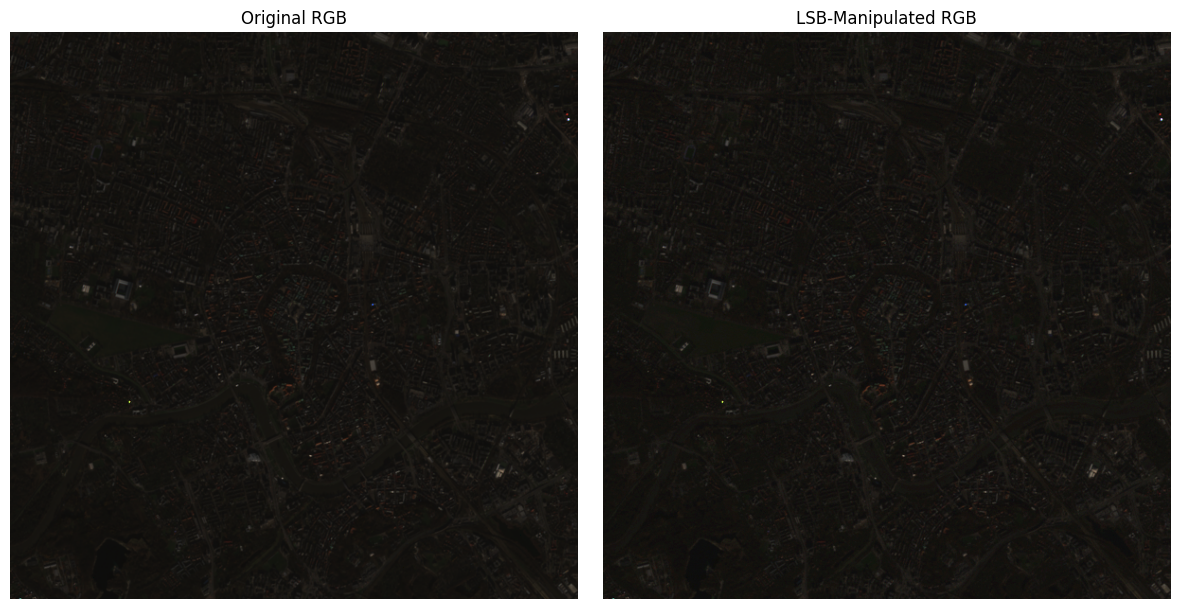

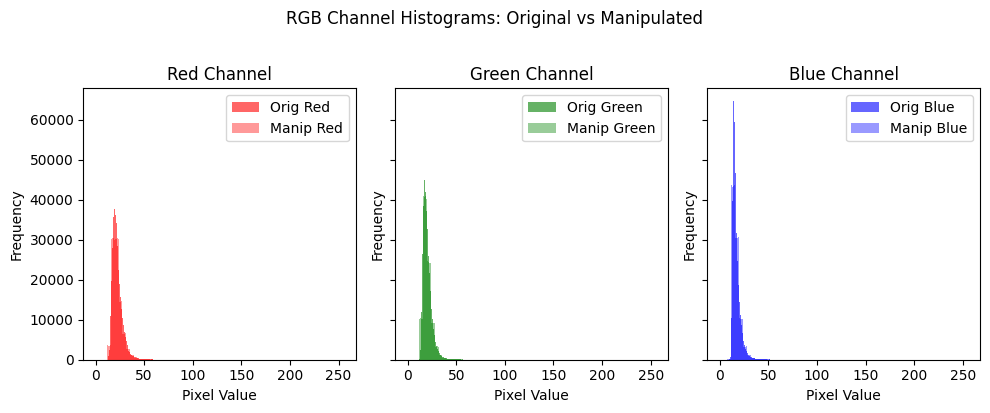

Mean pixel difference per channel: [1.25023889 1.25298889 1.23373056]
Max pixel difference per channel: [3 3 3]
Overall mean pixel difference: 1.2456527777777777


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_to_uint8(band):
    band = band.astype(float)
    band = (band - band.min()) / (band.max() - band.min()) * 255
    return band.astype(np.uint8)

# Normalize each Sentinel-2 band to 8-bit
r = normalize_to_uint8(b4_crop_k)
g = normalize_to_uint8(b3_crop_k)
b = normalize_to_uint8(b2_crop_k)
rgb = np.dstack((r, g, b))

rng = np.random.default_rng()
random_bits = rng.integers(0, 4, size=rgb.shape, dtype=np.uint8)

# Insert random bits
manip = (rgb & 0b11111100) | random_bits

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(rgb)
plt.title("Original RGB")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(manip)
plt.title("LSB-Manipulated RGB")
plt.axis("off")
plt.tight_layout()
plt.show()

# Histogram comparison per channel as separate subplots
channel_info = [(0, "red", "Red"), (1, "green", "Green"), (2, "blue", "Blue")]
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
for ax, (i, color, name) in zip(axes, channel_info):
    ax.hist(rgb[..., i].ravel(), bins=256, alpha=0.6, label=f"Orig {name}", color=color)
    ax.hist(manip[..., i].ravel(), bins=256, alpha=0.4, label=f"Manip {name}", color=color)
    ax.set_xlabel("Pixel Value")
    ax.set_ylabel("Frequency")
    ax.set_title(f"{name} Channel")
    ax.legend(loc="upper right")
fig.suptitle("RGB Channel Histograms: Original vs Manipulated", y=1.02)
fig.tight_layout()
plt.show()

# Quantitative difference 
diff = np.abs(rgb.astype(int) - manip.astype(int))
print("Mean pixel difference per channel:", diff.mean(axis=(0,1)))
print("Max pixel difference per channel:", diff.max(axis=(0,1)))
print("Overall mean pixel difference:", diff.mean())


I can't see a difference between the original and manipulated image, but the histograms clearly show that there is some. Theoretically if we know what the values are supposed to be, we can spot augmented images, but that would require already having the original. Additionally, it wouldn't be clear which one is changed (we see a difference not necessarily knowing which one is fake. if i switched the labels orig/manip, noone would know).